In [8]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score,f1_score
from sklearn.metrics import cohen_kappa_score


#Global Parameters and Variables loaded 
import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [9]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()

        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


# Set here the Model that should be fintuned

In [10]:
#Run1:
#Pretrain_model_dir = "./results/FIRST-2023-11-08-21-epochs-100-ADSMI"
#Run2:
#Pretrain_model_dir = "./results/CLR-2023-11-24-15-epochs-120-ADSMI-neu_V2"
#Run3:
Pretrain_model_dir = "./results/CLR-2023-12-08-16-epochs-250-ADSMI-neu_V5"

In [11]:



class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder

        # Fully connected layers for fine-tuning

        self.fc1 = nn.Linear(2048, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 256)   # Second FC layer
        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)
        return x


# class FineTuneModel(nn.Module):
#     def __init__(self, encoder, num_classes, dropout_probability=0.3):
#         super(FineTuneModel, self).__init__()
#         self.encoder = encoder

#         # Fully connected layers for fine-tuning
#         self.fc1 = nn.Linear(2048, 512)  # First FC layer
#         self.dropout1 = nn.Dropout(dropout_probability)  # Dropout layer after the first FC layer
#         self.fc2 = nn.Linear(512, 256)   # Second FC layer
#         self.dropout2 = nn.Dropout(dropout_probability)  # Dropout layer after the second FC layer
#         self.fc3 = nn.Linear(256, num_classes)  # Output layer

#     def forward(self, x):
#         x = self.encoder(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)  # Apply dropout after the first ReLU
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)  # Apply dropout after the second ReLU
#         x = self.fc3(x)
#         return x

class FineTuneModelFREEZE(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModelFREEZE, self).__init__()
        self.encoder = encoder

        # Freeze the encoder's parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Fully connected layers for fine-tuning
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

''''
class FineTuneModelFREZ(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModelFREZ, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        # dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x
'''

"'\nclass FineTuneModelFREZ(nn.Module):\n    def __init__(self, pretrained_autoencoder, num_classes):\n        super(FineTuneModelFREZ, self).__init__()\n        # Use the encoder from the pretrained autoencoder\n        self.encoder = pretrained_autoencoder.encoder\n\n        # Freeze the encoder\n        for param in self.encoder.parameters():\n            param.requires_grad = False\n\n        # Adaptive pooling layer\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n\n        # Classification head: Three fully connected layers\n        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer\n        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer\n        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes\n\n        # dropout for regularization\n        self.dropout = nn.Dropout(0.5)\n\n        # Non-linear activation function\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        # Pass inp

## Data


In [12]:
from Slit_and_validation_fun import *

train_df, test_df, val_df = train_test_ADSMI()

foldername = "RS96_F1_scores"
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)




print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64


### Model initalisation

In [13]:
# Hyperparameters
num_epochs = config.finetune_epochs 

weight_decay = 0  # L2 regularization
batch_size = config.batch_size
# Specify learning rates
learning_rate_encoder = 0.0003
learning_rate_fc = 0.0005
learning_rate = learning_rate_encoder


#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = 20#config.patience 
early_stop_counter = 0


# Load the entire pre-trained model (from your contrastive training)
#pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint.pth')
pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint_17.pth')

# Load the pre-trained encoder
encoder_trained = pretrained_model.encoder

# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(encoder_trained, num_classes).to(device)
#model = FineTuneModelFREEZE(encoder_trained, num_classes).to(device)



# Separate parameters of encoder and fully connected layers
encoder_params = model.encoder.parameters()
fc_params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())

# Create parameter groups with different learning rates
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': learning_rate_encoder},
    {'params': fc_params, 'lr': learning_rate_fc}
])


# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.6, verbose=True)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)
foldername = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
#new folder path
finetune_results_dir = f'./finetune_results/FT_ADSMI_{foldername}'#{datetime.datetime.now().strftime("%Y-%m-%d-%H")}_V4lradj'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on CONTRASTIVE LOSS PRETRAIN{data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate_encoder}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
val_losses = []
best_accuracy = 0
best_f1_macro_avg = 0
best_loss = 1000
early_stop_counter = 0
save_counter = 0
save_start = 0
f1_score_scores = []
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

In [14]:
#count parameters of pretrain model
pytorch_total_params = sum(p.numel() for p in pretrained_model.parameters())
print(pytorch_total_params)

30015656


In [15]:

from sklearn.metrics import f1_score as calculate_f1_score


for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    all_predicted = []
    all_labels = []
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy, loss, and now F1 score
    accuracy = correct_predictions / total_samples

    # Calculate macro avg f1 score using the alias
    f1_macro_avg = calculate_f1_score(all_labels, all_predicted, average='macro')
    f1_score_scores.append(f1_macro_avg)

    if f1_macro_avg > best_f1_macro_avg and save_counter >= save_start:
        best_f1_macro_avg = f1_macro_avg
        torch.save(model, finetune_results_dir + '/checkpoint_best_f1.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best F1 Score improved on epoch {epoch}: {best_f1_macro_avg:.4f}\n")

    if correct_predictions / total_samples > best_accuracy and save_counter >= save_start:
        best_accuracy = accuracy
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss and save_counter >= save_start:
        best_loss = avg_val_loss
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    save_counter += 1
    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%", f"Val F1 Score: {f1_macro_avg:.4f}")
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

100%|██████████| 236/236 [00:28<00:00,  8.34it/s]


Epoch [1/120], Train Loss: 0.6388, Val Loss: 0.3803, Val Accuracy: 88.35% Val F1 Score: 0.7663


100%|██████████| 236/236 [00:26<00:00,  9.07it/s]


Epoch [2/120], Train Loss: 0.4809, Val Loss: 0.5374, Val Accuracy: 76.27% Val F1 Score: 0.7320


100%|██████████| 236/236 [00:25<00:00,  9.08it/s]


Epoch [3/120], Train Loss: 0.4488, Val Loss: 0.3790, Val Accuracy: 84.32% Val F1 Score: 0.8164


100%|██████████| 236/236 [00:26<00:00,  9.02it/s]


Epoch [4/120], Train Loss: 0.4266, Val Loss: 0.3590, Val Accuracy: 90.04% Val F1 Score: 0.8081


100%|██████████| 236/236 [00:26<00:00,  9.02it/s]


Epoch [5/120], Train Loss: 0.3818, Val Loss: 0.2840, Val Accuracy: 90.25% Val F1 Score: 0.8255


100%|██████████| 236/236 [00:25<00:00,  9.14it/s]


Epoch [6/120], Train Loss: 0.3834, Val Loss: 0.2547, Val Accuracy: 92.16% Val F1 Score: 0.8798


100%|██████████| 236/236 [00:30<00:00,  7.72it/s]


Epoch [7/120], Train Loss: 0.3539, Val Loss: 0.2875, Val Accuracy: 88.98% Val F1 Score: 0.8308


100%|██████████| 236/236 [00:30<00:00,  7.73it/s]


Epoch [8/120], Train Loss: 0.3458, Val Loss: 0.2634, Val Accuracy: 90.68% Val F1 Score: 0.8536


100%|██████████| 236/236 [00:30<00:00,  7.86it/s]


Epoch [9/120], Train Loss: 0.3328, Val Loss: 0.3220, Val Accuracy: 90.25% Val F1 Score: 0.8647


100%|██████████| 236/236 [00:30<00:00,  7.64it/s]


Epoch [10/120], Train Loss: 0.3196, Val Loss: 0.3193, Val Accuracy: 89.62% Val F1 Score: 0.7679


100%|██████████| 236/236 [00:30<00:00,  7.78it/s]


Epoch [11/120], Train Loss: 0.3221, Val Loss: 0.2806, Val Accuracy: 91.10% Val F1 Score: 0.8534


100%|██████████| 236/236 [00:30<00:00,  7.66it/s]


Epoch [12/120], Train Loss: 0.3375, Val Loss: 0.2533, Val Accuracy: 92.16% Val F1 Score: 0.9071


100%|██████████| 236/236 [00:31<00:00,  7.59it/s]


Epoch [13/120], Train Loss: 0.3115, Val Loss: 0.2302, Val Accuracy: 92.16% Val F1 Score: 0.8772


100%|██████████| 236/236 [00:30<00:00,  7.68it/s]


Epoch [14/120], Train Loss: 0.3015, Val Loss: 0.3315, Val Accuracy: 86.86% Val F1 Score: 0.7920


100%|██████████| 236/236 [00:29<00:00,  7.88it/s]


Epoch [15/120], Train Loss: 0.3180, Val Loss: 0.3136, Val Accuracy: 89.62% Val F1 Score: 0.7842


100%|██████████| 236/236 [00:31<00:00,  7.60it/s]


Epoch [16/120], Train Loss: 0.2972, Val Loss: 0.2950, Val Accuracy: 90.47% Val F1 Score: 0.8555


100%|██████████| 236/236 [00:26<00:00,  9.06it/s]


Epoch [17/120], Train Loss: 0.2905, Val Loss: 0.2080, Val Accuracy: 92.58% Val F1 Score: 0.9037


100%|██████████| 236/236 [00:26<00:00,  8.95it/s]


Epoch [18/120], Train Loss: 0.2740, Val Loss: 0.2734, Val Accuracy: 89.83% Val F1 Score: 0.8617


100%|██████████| 236/236 [00:26<00:00,  8.86it/s]


Epoch [19/120], Train Loss: 0.2854, Val Loss: 0.2568, Val Accuracy: 91.53% Val F1 Score: 0.7872


100%|██████████| 236/236 [00:27<00:00,  8.72it/s]


Epoch [20/120], Train Loss: 0.2768, Val Loss: 0.2556, Val Accuracy: 88.98% Val F1 Score: 0.8274


100%|██████████| 236/236 [00:26<00:00,  8.89it/s]


Epoch [21/120], Train Loss: 0.2765, Val Loss: 0.2297, Val Accuracy: 91.95% Val F1 Score: 0.8844


100%|██████████| 236/236 [00:26<00:00,  8.85it/s]


Epoch [22/120], Train Loss: 0.2607, Val Loss: 0.2713, Val Accuracy: 89.62% Val F1 Score: 0.8870


100%|██████████| 236/236 [00:26<00:00,  8.78it/s]


Epoch [23/120], Train Loss: 0.2788, Val Loss: 0.2449, Val Accuracy: 91.74% Val F1 Score: 0.9036


100%|██████████| 236/236 [00:27<00:00,  8.65it/s]


Epoch [24/120], Train Loss: 0.2752, Val Loss: 0.3866, Val Accuracy: 88.56% Val F1 Score: 0.8633


100%|██████████| 236/236 [00:27<00:00,  8.54it/s]


Epoch [25/120], Train Loss: 0.2533, Val Loss: 0.2374, Val Accuracy: 91.31% Val F1 Score: 0.8990


100%|██████████| 236/236 [00:27<00:00,  8.73it/s]


Epoch [26/120], Train Loss: 0.2552, Val Loss: 0.2582, Val Accuracy: 90.25% Val F1 Score: 0.8873


100%|██████████| 236/236 [00:27<00:00,  8.73it/s]


Epoch [27/120], Train Loss: 0.2462, Val Loss: 0.2900, Val Accuracy: 91.74% Val F1 Score: 0.9012


100%|██████████| 236/236 [00:26<00:00,  8.80it/s]


Epoch 00028: reducing learning rate of group 0 to 1.8000e-04.
Epoch 00028: reducing learning rate of group 1 to 3.0000e-04.
Epoch [28/120], Train Loss: 0.2469, Val Loss: 0.2371, Val Accuracy: 91.53% Val F1 Score: 0.8957


100%|██████████| 236/236 [00:26<00:00,  8.76it/s]


Epoch [29/120], Train Loss: 0.2253, Val Loss: 0.2630, Val Accuracy: 91.95% Val F1 Score: 0.9082


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch [30/120], Train Loss: 0.2144, Val Loss: 0.2527, Val Accuracy: 90.68% Val F1 Score: 0.8919


100%|██████████| 236/236 [00:26<00:00,  8.80it/s]


Epoch [31/120], Train Loss: 0.2138, Val Loss: 0.2246, Val Accuracy: 91.53% Val F1 Score: 0.9049


100%|██████████| 236/236 [00:26<00:00,  8.80it/s]


Epoch [32/120], Train Loss: 0.2068, Val Loss: 0.2348, Val Accuracy: 91.95% Val F1 Score: 0.8987


100%|██████████| 236/236 [00:26<00:00,  8.77it/s]


Epoch [33/120], Train Loss: 0.2153, Val Loss: 0.2249, Val Accuracy: 93.01% Val F1 Score: 0.9064


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch [34/120], Train Loss: 0.2022, Val Loss: 0.2050, Val Accuracy: 92.58% Val F1 Score: 0.9035


100%|██████████| 236/236 [00:26<00:00,  8.77it/s]


Epoch [35/120], Train Loss: 0.2106, Val Loss: 0.2869, Val Accuracy: 88.56% Val F1 Score: 0.8515


100%|██████████| 236/236 [00:26<00:00,  8.79it/s]


Epoch [36/120], Train Loss: 0.2117, Val Loss: 0.2430, Val Accuracy: 91.74% Val F1 Score: 0.9179


100%|██████████| 236/236 [00:26<00:00,  8.79it/s]


Epoch [37/120], Train Loss: 0.2022, Val Loss: 0.2740, Val Accuracy: 91.31% Val F1 Score: 0.9016


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch [38/120], Train Loss: 0.1941, Val Loss: 0.2756, Val Accuracy: 90.04% Val F1 Score: 0.8909


100%|██████████| 236/236 [00:26<00:00,  8.78it/s]


Epoch [39/120], Train Loss: 0.2106, Val Loss: 0.2333, Val Accuracy: 91.53% Val F1 Score: 0.8924


100%|██████████| 236/236 [00:26<00:00,  8.80it/s]


Epoch [40/120], Train Loss: 0.1951, Val Loss: 0.2133, Val Accuracy: 90.89% Val F1 Score: 0.8754


100%|██████████| 236/236 [00:27<00:00,  8.61it/s]


Epoch [41/120], Train Loss: 0.1964, Val Loss: 0.2541, Val Accuracy: 90.68% Val F1 Score: 0.8800


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch [42/120], Train Loss: 0.1978, Val Loss: 0.2333, Val Accuracy: 89.83% Val F1 Score: 0.8697


100%|██████████| 236/236 [00:26<00:00,  8.76it/s]


Epoch [43/120], Train Loss: 0.1866, Val Loss: 0.2842, Val Accuracy: 90.47% Val F1 Score: 0.8874


100%|██████████| 236/236 [00:26<00:00,  8.82it/s]


Epoch [44/120], Train Loss: 0.1910, Val Loss: 0.2269, Val Accuracy: 91.95% Val F1 Score: 0.8997


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch 00045: reducing learning rate of group 0 to 1.0800e-04.
Epoch 00045: reducing learning rate of group 1 to 1.8000e-04.
Epoch [45/120], Train Loss: 0.1927, Val Loss: 0.2836, Val Accuracy: 89.62% Val F1 Score: 0.8312


100%|██████████| 236/236 [00:26<00:00,  8.78it/s]


Epoch [46/120], Train Loss: 0.1697, Val Loss: 0.2328, Val Accuracy: 92.37% Val F1 Score: 0.8978


100%|██████████| 236/236 [00:26<00:00,  8.77it/s]


Epoch [47/120], Train Loss: 0.1721, Val Loss: 0.2402, Val Accuracy: 90.25% Val F1 Score: 0.8935


100%|██████████| 236/236 [00:26<00:00,  8.76it/s]


Epoch [48/120], Train Loss: 0.1533, Val Loss: 0.2819, Val Accuracy: 90.68% Val F1 Score: 0.8914


100%|██████████| 236/236 [00:26<00:00,  8.80it/s]


Epoch [49/120], Train Loss: 0.1678, Val Loss: 0.2650, Val Accuracy: 89.83% Val F1 Score: 0.8964


100%|██████████| 236/236 [00:26<00:00,  8.78it/s]


Epoch [50/120], Train Loss: 0.1562, Val Loss: 0.2287, Val Accuracy: 91.74% Val F1 Score: 0.8921


100%|██████████| 236/236 [00:26<00:00,  8.77it/s]


Epoch [51/120], Train Loss: 0.1709, Val Loss: 0.2661, Val Accuracy: 90.04% Val F1 Score: 0.8801


100%|██████████| 236/236 [00:26<00:00,  8.75it/s]


Epoch [52/120], Train Loss: 0.1721, Val Loss: 0.2428, Val Accuracy: 90.25% Val F1 Score: 0.8806


100%|██████████| 236/236 [00:27<00:00,  8.74it/s]


Epoch [53/120], Train Loss: 0.1605, Val Loss: 0.2872, Val Accuracy: 89.83% Val F1 Score: 0.8749


100%|██████████| 236/236 [00:33<00:00,  7.10it/s]


Epoch [54/120], Train Loss: 0.1685, Val Loss: 0.2583, Val Accuracy: 91.95% Val F1 Score: 0.9053


100%|██████████| 236/236 [00:33<00:00,  6.97it/s]


Epoch [55/120], Train Loss: 0.1757, Val Loss: 0.2591, Val Accuracy: 91.10% Val F1 Score: 0.8958
Early stopping on epoch 55


### Losses Plot

./finetune_results/FT_ADSMI_2024-05-07-18-04-53


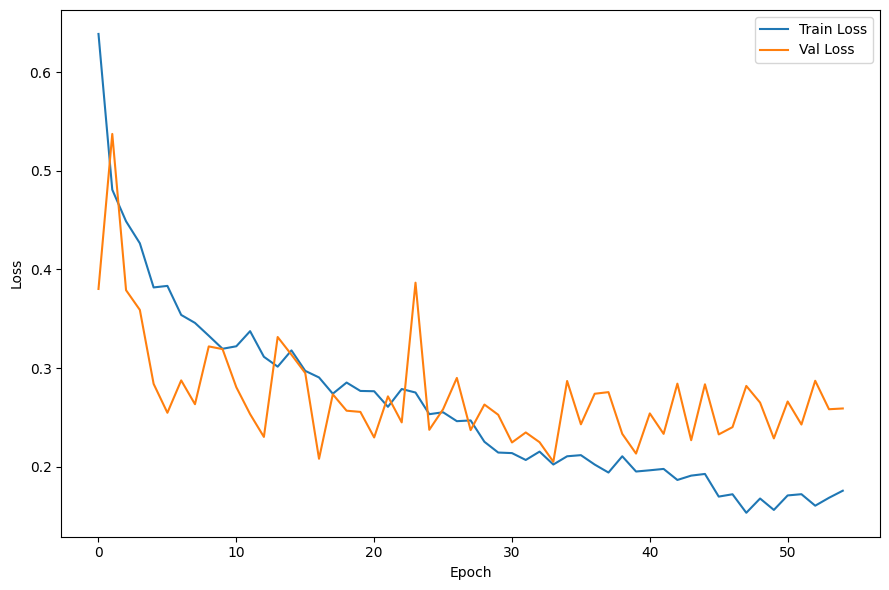

In [16]:
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')


# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()



#system sleep for 2
time.sleep(2)
print(finetune_results_dir)
# Save the plot
plt.savefig(f'{finetune_results_dir}/loss_plot.png')

plt.show()

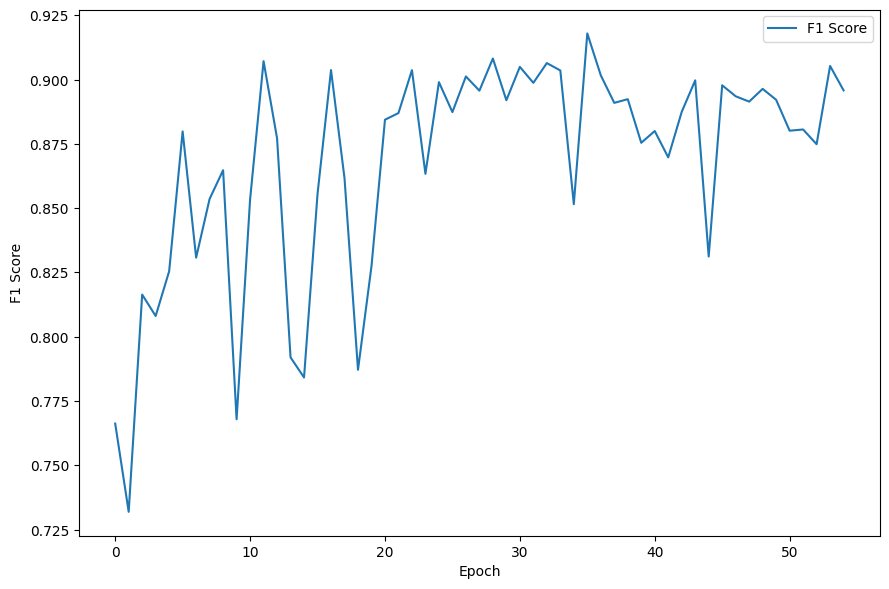

In [17]:
#plot f1 scores
plt.figure(figsize=(9, 6))
plt.plot(f1_score_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()

#pickle the f1 scores
import pickle
with open(f'{finetune_results_dir}/f1_scores.pkl', 'wb') as f:
    pickle.dump(f1_score_scores, f)


Evaluation Results:
Balanced Accuracy2: 91.79%
Test Accuracy: 91.95%

Evaluation Results:
Accuracy: 91.95%
Precision: 92.01%
Recall: 91.79%
F1-score: 91.75%
Kappa: 87.27%
                         precision    recall  f1-score   support

            [Kreischen]     0.8903    0.9591    0.9234       220
[Kreischen][Quietschen]     0.8684    0.9167    0.8919        72
              [Negativ]     0.9931    0.8675    0.9260       166
           [Quietschen]     0.9286    0.9286    0.9286        14

               accuracy                         0.9195       472
              macro avg     0.9201    0.9179    0.9175       472
           weighted avg     0.9243    0.9195    0.9197       472



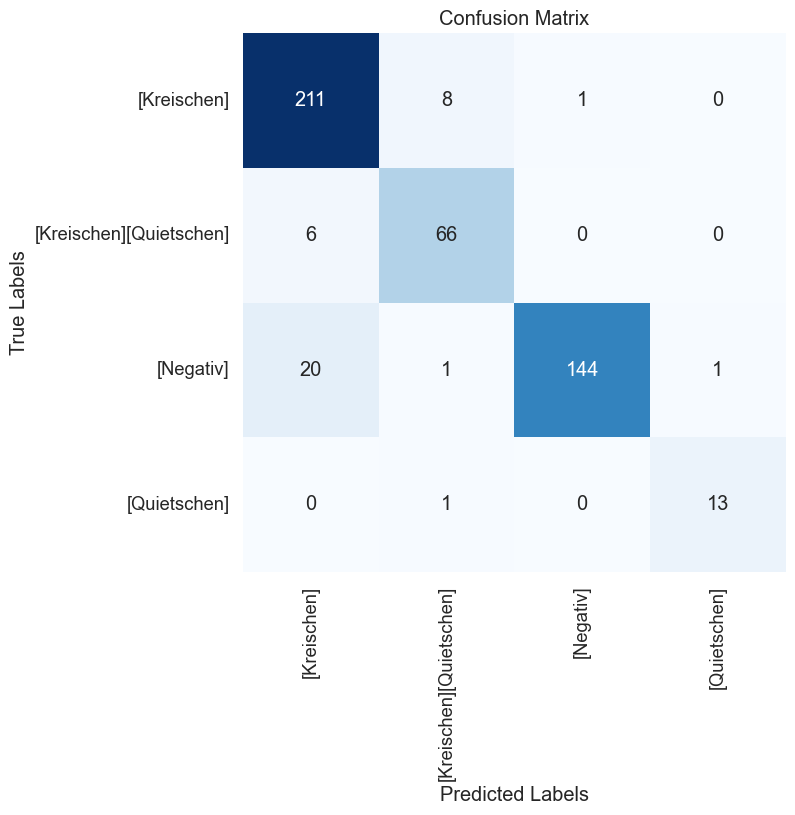

In [18]:
validation_fun(finetune_results_dir,'/Full_model_checkpoint.pth',"full_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)




Evaluation Results:
Balanced Accuracy2: 93.59%
Test Accuracy: 93.43%

Evaluation Results:
Accuracy: 93.43%
Precision: 95.11%
Recall: 93.59%
F1-score: 94.25%
Kappa: 89.56%
                         precision    recall  f1-score   support

            [Kreischen]     0.8992    0.9727    0.9345       220
[Kreischen][Quietschen]     0.9118    0.8611    0.8857        72
              [Negativ]     0.9934    0.9096    0.9497       166
           [Quietschen]     1.0000    1.0000    1.0000        14

               accuracy                         0.9343       472
              macro avg     0.9511    0.9359    0.9425       472
           weighted avg     0.9372    0.9343    0.9343       472



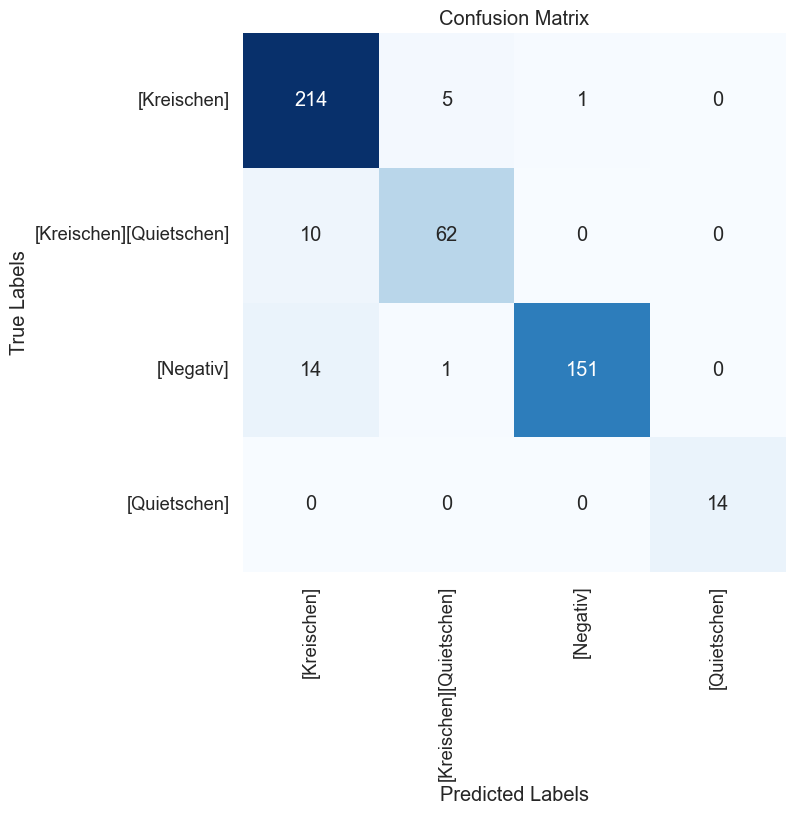

In [19]:
validation_fun(finetune_results_dir,'/checkpoint_best_f1.pth',"f1_model",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)





Evaluation Results:
Balanced Accuracy2: 84.70%
Test Accuracy: 91.95%

Evaluation Results:
Accuracy: 91.95%
Precision: 90.19%
Recall: 84.70%
F1-score: 86.83%
Kappa: 87.27%
                         precision    recall  f1-score   support

            [Kreischen]     0.9130    0.9545    0.9333       220
[Kreischen][Quietschen]     0.8077    0.8750    0.8400        72
              [Negativ]     0.9870    0.9157    0.9500       166
           [Quietschen]     0.9000    0.6429    0.7500        14

               accuracy                         0.9195       472
              macro avg     0.9019    0.8470    0.8683       472
           weighted avg     0.9226    0.9195    0.9195       472



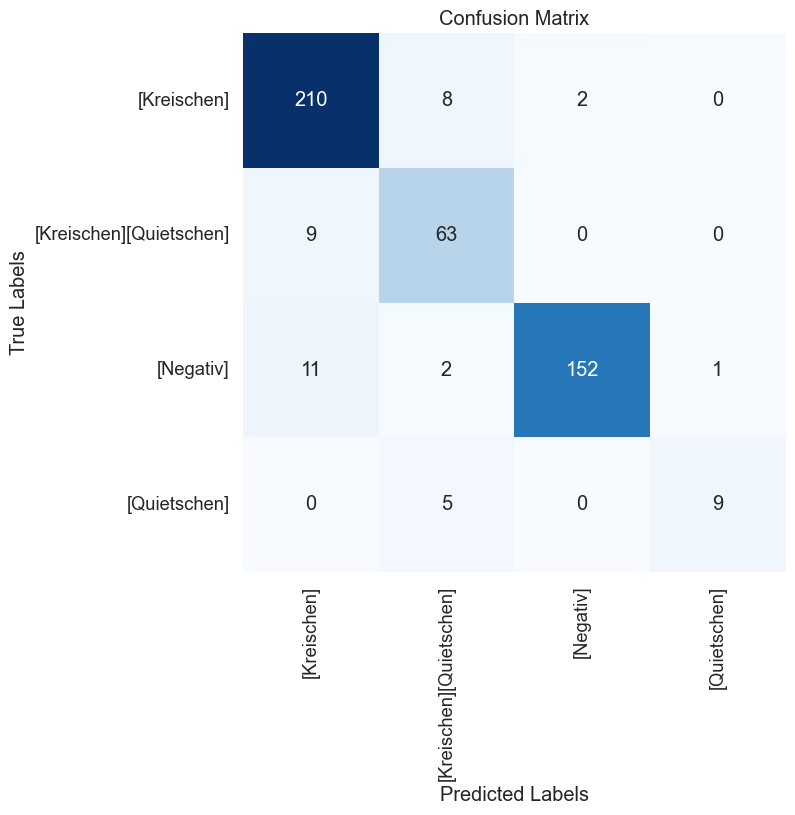

In [20]:
validation_fun(finetune_results_dir,'/checkpoint.pth',"best_accuracy",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)



Evaluation Results:
Balanced Accuracy2: 91.57%
Test Accuracy: 92.16%

Evaluation Results:
Accuracy: 92.16%
Precision: 90.21%
Recall: 91.57%
F1-score: 90.46%
Kappa: 87.55%
                         precision    recall  f1-score   support

            [Kreischen]     0.9119    0.9409    0.9262       220
[Kreischen][Quietschen]     0.9322    0.7639    0.8397        72
              [Negativ]     0.9408    0.9578    0.9493       166
           [Quietschen]     0.8235    1.0000    0.9032        14

               accuracy                         0.9216       472
              macro avg     0.9021    0.9157    0.9046       472
           weighted avg     0.9225    0.9216    0.9204       472



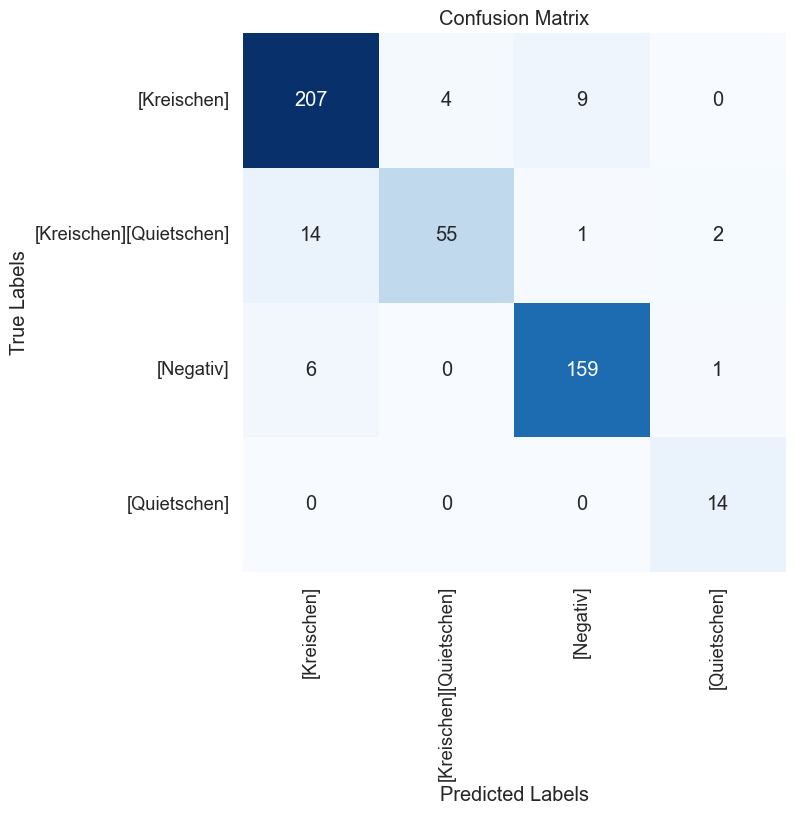

In [21]:
validation_fun(finetune_results_dir,'/checkpoint_best_loss.pth',"best_loss",val_df,config.finetune_epochs,config.batch_size,learning_rate,weight_decay)